In [ ]:
# default_exp dataset

# Dataset

> API details.

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
import copy

import torch
from torch.utils.data import DataLoader, Dataset, RandomSampler
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


import pytorch_lightning as pl
from tqdm import tqdm

import cv2
from PIL import Image
import albumentations as A

from isic.config import *
from isic.sampler import ImbalancedDatasetSampler

In [ ]:
#export
class SkinLabels():
    lesion_type_dict = {
        'nv': 'Melanocytic nevi',
        'mel': 'Melanoma',
        'bkl': 'Benign keratosis-like lesions ',
        'bcc': 'Basal cell carcinoma',
        'akiec': 'Actinic keratoses',
        'vasc': 'Vascular lesions',
        'df': 'Dermatofibroma'
    }

    lesion_type_vi_dict = {
        'nv': 'Nốt ruồi',
        'mel': 'Ung thư hắc tố',
        'bkl': 'U sừng hóa ác tính ',
        'bcc': 'U da ung thư tế bào đáy',
        'akiec': 'Dày sừng quang hóa',
        'vasc': 'Thương tổn mạch máu',
        'df': 'U da lành tính'
    }

In [ ]:
#export
def preprocess_df(df, valid_size=0.2, seed=AppConfig.SEED, image_label_only=False, img_path = PathConfig.IMAGE_PATH):

    df['path'] = img_path + '/' + df['image_id'] + '.jpg'
    df['label_fullstr'] = df['dx'].map(SkinLabels.lesion_type_dict.get)

    label_str = pd.Categorical(df['label_fullstr'])
    df['label_index'] = label_str.codes

    df_undup = df.groupby('lesion_id').count()
    df_undup = df_undup[df_undup['image_id'] == 1]
    df_undup.reset_index(inplace=True)

    _, valid = train_test_split(df_undup['lesion_id'], test_size=valid_size, 
                                random_state=seed, 
                                stratify=df_undup['label_index'])
    valid = set(valid)
    df['val'] = df['lesion_id'].apply(lambda x: 1 if str(x) in valid else 0)

    df_train = df[df['val'] == 0]
    df_valid = df[df['val'] == 1]

    dest_df_train = df_train.reset_index(drop=True)
    dest_df_valid = df_valid.reset_index(drop=True)
    if not image_label_only:
        return dest_df_train, dest_df_valid, list(label_str.categories)
    else:
        train_imgs = []
        val_imgs = []
        i = 0
        for df in (dest_df_train, dest_df_valid):
            for j, path in enumerate(df['path']):
                x = np.array(Image.open(path))
                y = torch.tensor(int(df['label_index'][j]))
                if i == 0:
                    train_imgs.append((x, y))
                else:
                    val_imgs.append((x, y))
            i += 1
        return train_imgs, val_imgs, list(label_str.categories)

In [ ]:
#export
class SkinDataset(Dataset):
    def __init__(self, df, transform=None, labels=None):
        self.df = df
        self.transform = transform
        self.labels = labels

    def __getitem__(self, i):
        if i >= len(self): raise IndexError
        image = cv2.imread(self.df['path'][i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        y = torch.tensor(int(self.df['label_index'][i]))

        # Albumentation only
        if self.transform is not None:
            res = self.transform(image=image)
            image = res['image'].astype(np.float32)
        else:
            image = image.astype(np.float32)

        image = image.transpose(2, 0, 1)
        image = torch.tensor(image).float()

        return {"img": image, "label": y}

    def __len__(self):
        return len(self.df)

    def show_image(self, index=None):
        dataset = self
        n_samples = len(dataset)

        if not index:
            index = int(np.random.random()*n_samples)
        else:
            if index >= n_samples or index < 0:
                print('Invalid index.')
                return

        d = dataset[index]

        plt.imshow(d['img'].permute(1,2,0))
        plt.axis('off')
        plt.title(self.labels[d['label']] if self.labels else d['label'])

    def show_grid(self, n_rows=5, n_cols=5):
        dataset = self
        array = torch.utils.data.Subset(dataset, np.random.choice(len(dataset), n_rows*n_cols, replace=False))

        plt.figure(figsize=(12, 12))
        for row in range(n_rows):
            for col in range(n_cols):
                index = n_cols * row + col
                plt.subplot(n_rows, n_cols, index + 1)
                plt.imshow(array[index]['img'].permute(1, 2, 0))
                plt.axis('off')
                label = self.labels[int(array[index]['label'])] if self.labels else int(array[index]['label'])
                plt.title(label, fontsize=12)
        plt.tight_layout()

In [ ]:
#export
class SkinDataModule(pl.LightningDataModule):
    def __init__(self, image_size=224, valid_size=0.2, bs=64, df_path=PathConfig.CSV_PATH, imbalanced_sampler=True, transform=None, cutout=True):
        self.df_path = df_path
        self.valid_size = 0.2
        self.bs = bs
        self.imbalanced_sampler = imbalanced_sampler
        
        self.train_transform = transform
        if self.train_transform is None:
            self.train_transform = get_default_train_transform(image_size, cutout)
            
        self.val_transform = get_default_val_transform(image_size)
        
        self.dims = (3, image_size, image_size)

    def setup(self, stage):
        def _get_label(dataset, idx):
            return int(dataset.df['label_index'][idx])
        
        if stage == 'fit' or stage is None:
            df = pd.read_csv(self.df_path)
            train_df, valid_df, self.labels = preprocess_df(df, self.valid_size)
            self.train_ds = SkinDataset(train_df, self.train_transform, self.labels)
            self.val_ds = SkinDataset(valid_df, self.val_transform, self.labels)

            if self.imbalanced_sampler:
                self.sampler = ImbalancedDatasetSampler(self.train_ds, callback_get_label=_get_label)
            else:
                self.sampler = RandomSampler(self.train_ds)

            self.dims = tuple(self.train_ds[0]["img"].shape)

        if stage == 'test':
            #TODO
            pass
        
    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.bs, 
                          sampler=self.sampler,
                          num_workers=4
                         )

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.bs, num_workers=4)

    def test_dataloader(self):
        #TODO
        return DataLoader(self.val_ds, batch_size=self.bs, num_workers=4)

In [ ]:
#export
def get_default_train_transform(image_size=224, cut_out=True, no_norm=False):
    transforms_train = [
        A.Transpose(p=0.5),
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightness(limit=0.2, p=0.75),
        A.RandomContrast(limit=0.2, p=0.75),
        A.OneOf([
            A.MotionBlur(blur_limit=5),
            A.MedianBlur(blur_limit=5),
            A.GaussianBlur(blur_limit=5),
            A.GaussNoise(var_limit=(5.0, 30.0)),
        ], p=0.7),

        A.OneOf([
            A.OpticalDistortion(distort_limit=1.0),
            A.GridDistortion(num_steps=5, distort_limit=1.),
            A.ElasticTransform(alpha=3),
        ], p=0.7),

        A.CLAHE(clip_limit=4.0, p=0.7),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
        A.Resize(image_size, image_size)
    ]
    if cut_out:
        transforms_train.append(A.Cutout(max_h_size=int(image_size * 0.375), max_w_size=int(image_size * 0.375), num_holes=1, p=0.7))
    norm = A.Normalize()
    if no_norm:
        norm = A.Normalize(mean=0, std=1)
    transforms_train.append(norm)
    return A.Compose(transforms_train)

def get_default_val_transform(image_size=224):
    return A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize()
    ])

In [ ]:
dm = SkinDataModule(transform=get_default_train_transform(no_norm=True))
dm.prepare_data()
dm.setup('fit')

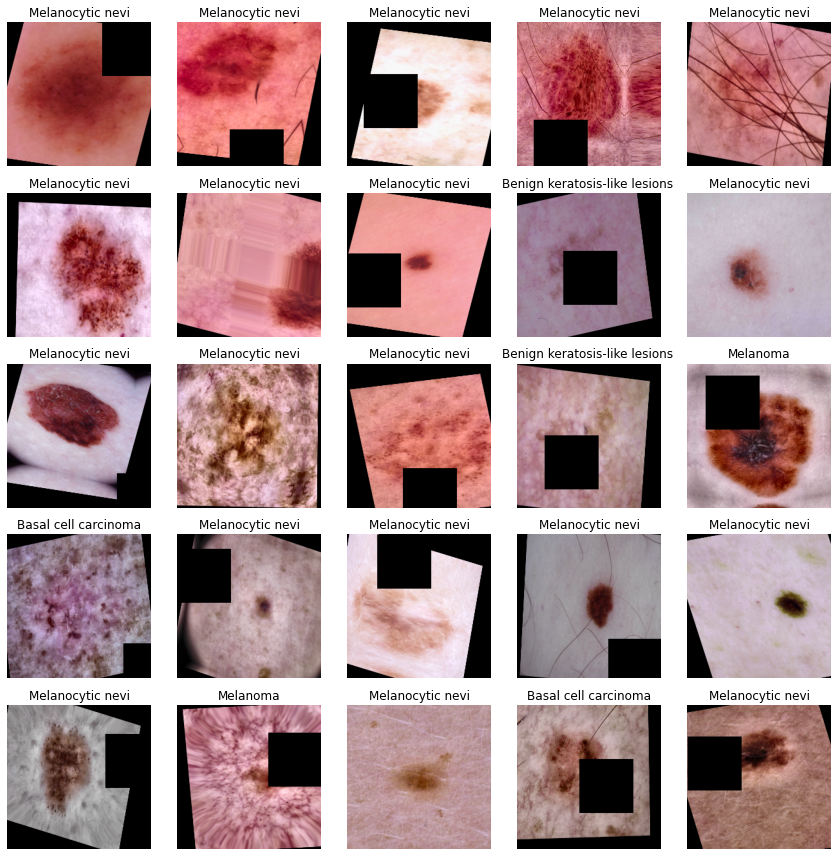

In [ ]:
dm.train_ds.show_grid()

In [ ]:
from nbdev.export import *
notebook2script('dataset_dict.ipynb')